In [15]:
import pandas as pd
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("../")) 

from src.data_processing import load_news, load_stock_data
from src.sentiment_analysis import compute_sentiment, aggregate_daily_sentiment
from src.stock_analysis import compute_daily_returns, merge_with_sentiment
from src.visualization import scatter_sentiment_vs_return, time_series_sentiment_vs_return

news_fp = "../data/raw_analyst_ratings.csv"
stock_data_dir = "../data/"
symbols = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']

MARKET_CLOSE_HOUR = 16
SHIFT_AFTER_HOURS = True


In [16]:
news = load_news(news_fp)

stock_data = load_stock_data(stock_data_dir, symbols)

print("News data:", news.shape)
print("Loaded stocks:", list(stock_data.keys()))


News data: (55987, 7)
Loaded stocks: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']


In [17]:
news[['polarity', 'subjectivity']] = news['headline'].apply(compute_sentiment)

if SHIFT_AFTER_HOURS:
    news['news_hour_utc'] = news['date'].dt.tz_convert('UTC').dt.hour
    news['mapped_date'] = news.apply(
        lambda r: r['date'].date() if r['news_hour_utc'] < MARKET_CLOSE_HOUR 
                  else r['date'].date() + pd.Timedelta(days=1),
        axis=1
    )
else:
    news['mapped_date'] = news['date'].dt.date

daily_sentiment = aggregate_daily_sentiment(news)
daily_sentiment.head()


,stock,date,avg_polarity,avg_subjectivity,article_count
0,A,2020-05-22,0.041667,0.083333,6
1,A,2020-05-23,0.000000,0.000000,1
2,A,2020-05-26,0.000000,0.000000,1
3,A,2020-06-03,0.000000,0.000000,1
4,A,2020-06-05,0.000000,0.000000,1


In [11]:
stock_returns = compute_daily_returns(stock_data)
for sym, df in stock_returns.items():
    print(sym, df.head())


AAPL          date     Close  daily_return
0  2009-01-02  2.721686           NaN
1  2009-01-05  2.836553      0.042204
2  2009-01-06  2.789767     -0.016494
3  2009-01-07  2.729484     -0.021609
4  2009-01-08  2.780169      0.018570
AMZN          date  Close  daily_return
0  2009-01-02  2.718           NaN
1  2009-01-05  2.703     -0.005519
2  2009-01-06  2.868      0.061043
3  2009-01-07  2.810     -0.020223
4  2009-01-08  2.858      0.017082
GOOG          date     Close  daily_return
0  2009-01-02  7.948608           NaN
1  2009-01-05  8.115089      0.020945
2  2009-01-06  8.263762      0.018321
3  2009-01-07  7.965677     -0.036071
4  2009-01-08  8.044340      0.009875
META          date      Close  daily_return
0  2012-05-18  37.995762           NaN
1  2012-05-21  33.821495     -0.109861
2  2012-05-22  30.810066     -0.089039
3  2012-05-23  31.803938      0.032258
4  2012-05-24  32.827625      0.032187
MSFT          date      Close  daily_return
0  2009-01-02  14.872976           N

In [12]:
merged_data = merge_with_sentiment(stock_returns, daily_sentiment)
for sym, df in merged_data.items():
    print(sym, df.head())


Sentiment Data Date Range: 2011-04-27 to 2020-06-12
Stock AAPL: Merged 2 rows (Intersection)
Stock AMZN: Merged 3 rows (Intersection)
Stock GOOG: Merged 5 rows (Intersection)
Stock META: Merged 0 rows (Intersection)
Stock MSFT: Merged 0 rows (Intersection)
Stock NVDA: Merged 6 rows (Intersection)
AAPL        date_x      Close  daily_return    date_key stock      date_y  \
0  2020-06-09  83.419868      0.031578  2020-06-09  AAPL  2020-06-09   
1  2020-06-10  85.566071      0.025728  2020-06-10  AAPL  2020-06-10   

   avg_polarity  avg_subjectivity  article_count  
0      0.053333          0.313333              1  
1      0.144613          0.271549              9  
AMZN        date_x       Close  daily_return    date_key stock      date_y  \
0  2020-06-09  130.042999      0.030427  2020-06-09  AMZN  2020-06-09   
1  2020-06-10  132.372498      0.017913  2020-06-10  AMZN  2020-06-10   
2  2020-06-11  127.898003     -0.033802  2020-06-11  AMZN  2020-06-11   

   avg_polarity  avg_subjecti

In [13]:
results = []

for sym in symbols:
    df = merged_data[sym].dropna(subset=['daily_return', 'avg_polarity'])
    
    if len(df) < 5:
        results.append({'stock': sym, 'n': len(df), 'pearson_r': None, 'p_value': None})
        continue
    
    r, p = pearsonr(df['avg_polarity'], df['daily_return'])
    results.append({'stock': sym, 'n': len(df), 'pearson_r': r, 'p_value': p})

results_df = pd.DataFrame(results).sort_values('pearson_r', ascending=False)
print(results_df)


  stock  n  pearson_r   p_value
5  NVDA  6   0.146662  0.781585
2  GOOG  5  -0.030588  0.961060
0  AAPL  2        NaN       NaN
1  AMZN  3        NaN       NaN
3  META  0        NaN       NaN
4  MSFT  0        NaN       NaN


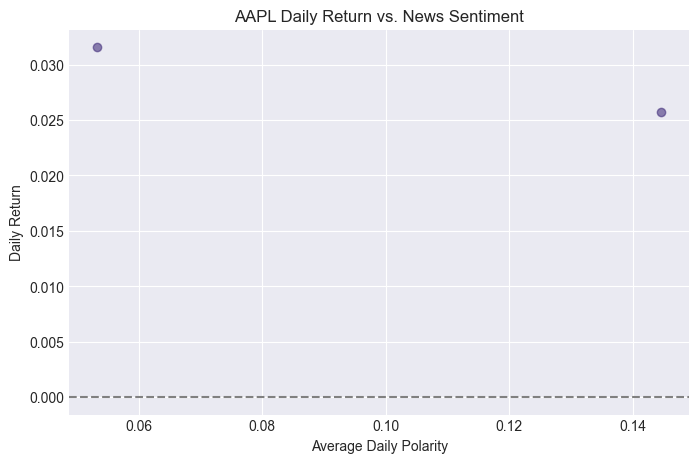

KeyError: 'date'

<Figure size 1200x400 with 0 Axes>

In [14]:
for sym in symbols:
    df = merged_data[sym].dropna(subset=['daily_return', 'avg_polarity'])
    
    if len(df) == 0:
        print(f"No data to plot for {sym}")
        continue
    
    scatter_sentiment_vs_return(df, sym)
    
    time_series_sentiment_vs_return(df, sym)
